In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df1 = pd.read_csv(r"Banana2_with_rot_hours.csv")
df2 = pd.read_csv(r"Banana3_with_rot_hours.csv")

In [4]:
df1

,Hour,MQ2,MQ3,MQ4,MQ5,MQ9,MQ135,Temp,Hum,Hours Left to Rot
0,0,210,385,192,241,127,329,33.2,49,109
1,1,202,365,188,229,128,339,33.2,48.6,108
2,2,201,350,198,224,127,321,33.5,49.8,107
3,3,196,355,186,219,128,308,33.5,50.4,106
4,4,190,345,184,213,128,298,33.6,51.3,105
...,...,...,...,...,...,...,...,...,...,...
176,176,283,459,243,264,160,357,32.4,57.5,0
177,177,271,448,247,283,159,371,32.1,54.9,0
178,178,267,439,255,300,160,382,32.3,54.5,0
179,179,247,432,264,302,159,429,32.7,51.8,0


In [5]:
df2

,Hour,MQ2,MQ3,MQ4,MQ5,MQ9,MQ135,Temp,Hum,Hours Left to Rot
0,0,244,433,241,340,126,428,30.4,59.1,94
1,1,242,420,239,335,127,432,30.4,58,93
2,2,252,462,246,356,128,424,32.4,48.7,92
3,3,241,462,236,341,127,401,32.8,48.9,91
4,4,241,468,235,333,127,405,32.6,47,90
...,...,...,...,...,...,...,...,...,...,...
221,221,262,499,275,342,149,424,32.6,55.2,0
222,222,267,522,276,331,147,417,33.1,55.8,0
223,223,283,534,252,303,147,398,32.8,56.9,0
224,224,262,510,261,331,147,400,32.7,55.3,0


In [6]:
# function for filling the missing values of temperature and humidity attributes
def fill_nan_values(df):
    df_filled = df.copy()
    
    df_filled['Temp'] = pd.to_numeric(df_filled['Temp'], errors='coerce')
    df_filled['Hum'] = pd.to_numeric(df_filled['Hum'], errors='coerce')
    
    df_filled['Temp'] = df_filled['Temp'].interpolate(method='linear').ffill().bfill().round(1)
    df_filled['Hum'] = df_filled['Hum'].interpolate(method='linear').ffill().bfill().round(1)
    
    return df_filled

df1 = fill_nan_values(df1)
df2 = fill_nan_values(df2)

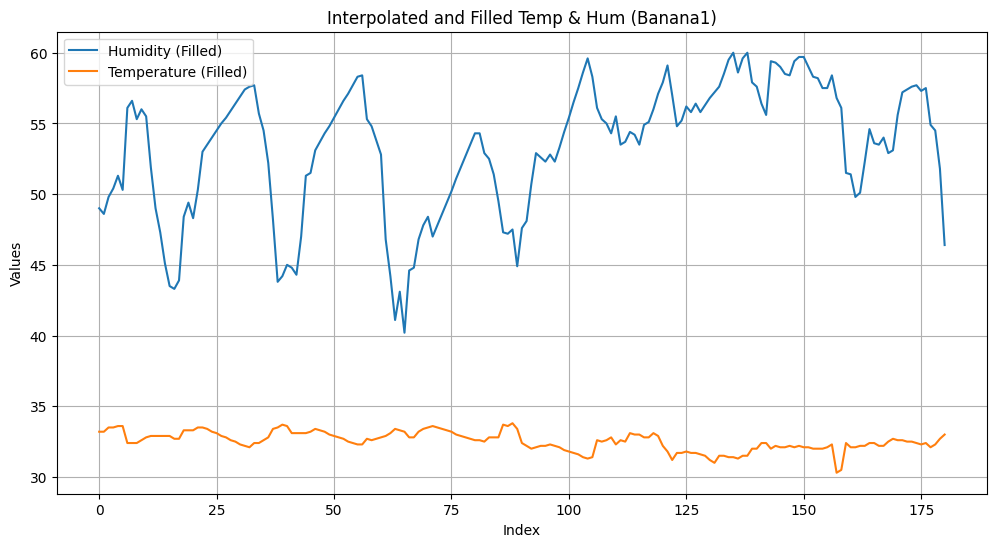

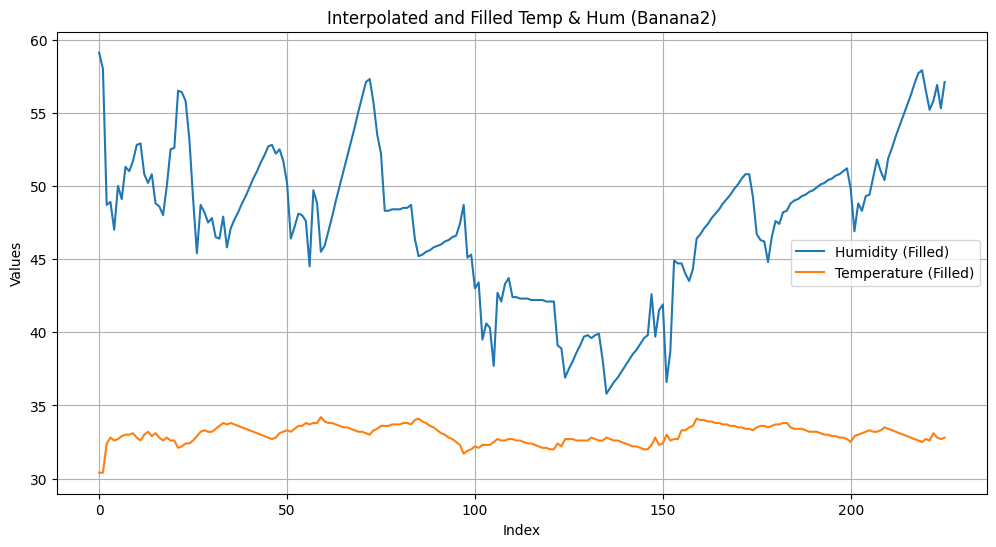

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df1['Hour'], df1['Hum'], label='Humidity (Filled)')
plt.plot(df1['Hour'], df1['Temp'], label='Temperature (Filled)')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Interpolated and Filled Temp & Hum (Banana1)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df2['Hour'], df2['Hum'], label='Humidity (Filled)')
plt.plot(df2['Hour'], df2['Temp'], label='Temperature (Filled)')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Interpolated and Filled Temp & Hum (Banana2)")
plt.legend()
plt.grid(True)
plt.show()

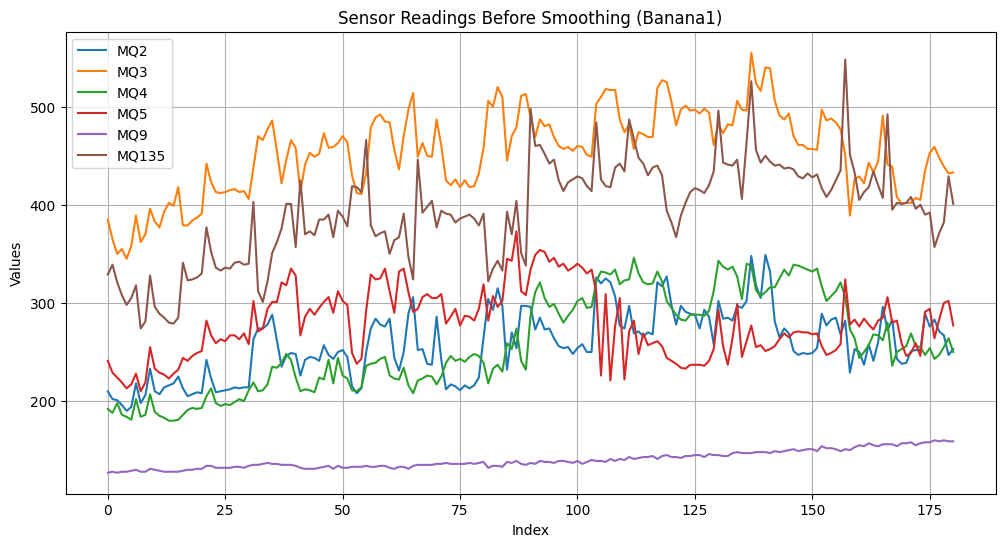

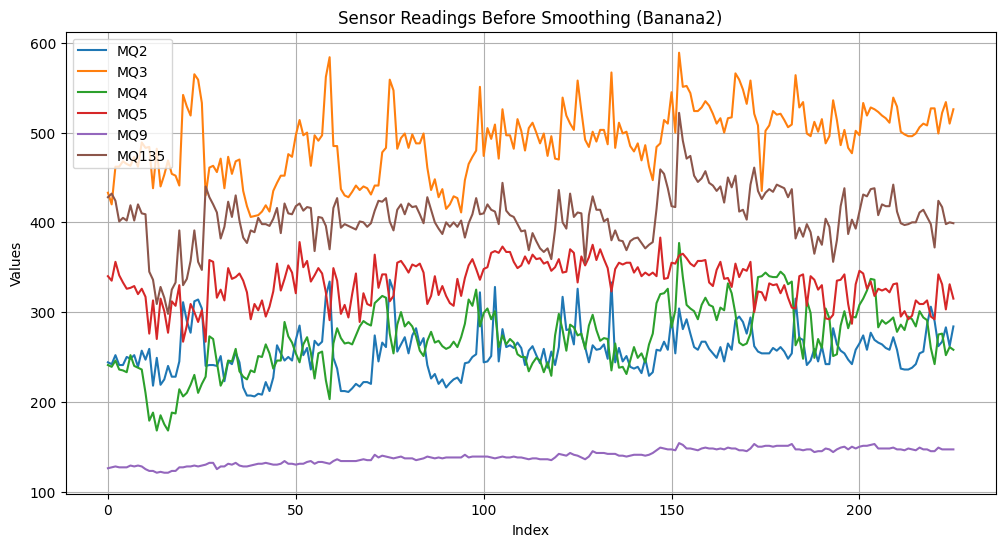

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df1['Hour'], df1['MQ2'], label='MQ2')
plt.plot(df1['Hour'], df1['MQ3'], label='MQ3')
plt.plot(df1['Hour'], df1['MQ4'], label='MQ4')
plt.plot(df1['Hour'], df1['MQ5'], label='MQ5')
plt.plot(df1['Hour'], df1['MQ9'], label='MQ9')
plt.plot(df1['Hour'], df1['MQ135'], label='MQ135')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Sensor Readings Before Smoothing (Banana1)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df2['Hour'], df2['MQ2'], label='MQ2')
plt.plot(df2['Hour'], df2['MQ3'], label='MQ3')
plt.plot(df2['Hour'], df2['MQ4'], label='MQ4')
plt.plot(df2['Hour'], df2['MQ5'], label='MQ5')
plt.plot(df2['Hour'], df2['MQ9'], label='MQ9')
plt.plot(df2['Hour'], df2['MQ135'], label='MQ135')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Sensor Readings Before Smoothing (Banana2)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# smoothing with rolling mean
df1['Hum'] = df1['Hum'].rolling(window=10, min_periods=1).mean()
df1['Temp'] = df1['Temp'].rolling(window=10, min_periods=1).mean()
df1['MQ2'] = df1['MQ2'].rolling(window=10, min_periods=1).mean()
df1['MQ3'] = df1['MQ3'].rolling(window=10, min_periods=1).mean()
df1['MQ4'] = df1['MQ4'].rolling(window=10, min_periods=1).mean()
df1['MQ5'] = df1['MQ5'].rolling(window=10, min_periods=1).mean()
df1['MQ9'] = df1['MQ9'].rolling(window=10, min_periods=1).mean()
df1['MQ135'] = df1['MQ135'].rolling(window=10, min_periods=1).mean()

df2['Hum'] = df2['Hum'].rolling(window=10, min_periods=1).mean()
df2['Temp'] = df2['Temp'].rolling(window=10, min_periods=1).mean()
df2['MQ2'] = df2['MQ2'].rolling(window=10, min_periods=1).mean()
df2['MQ3'] = df2['MQ3'].rolling(window=10, min_periods=1).mean()
df2['MQ4'] = df2['MQ4'].rolling(window=10, min_periods=1).mean()
df2['MQ5'] = df2['MQ5'].rolling(window=10, min_periods=1).mean()
df2['MQ9'] = df2['MQ9'].rolling(window=10, min_periods=1).mean()
df2['MQ135'] = df2['MQ135'].rolling(window=10, min_periods=1).mean()

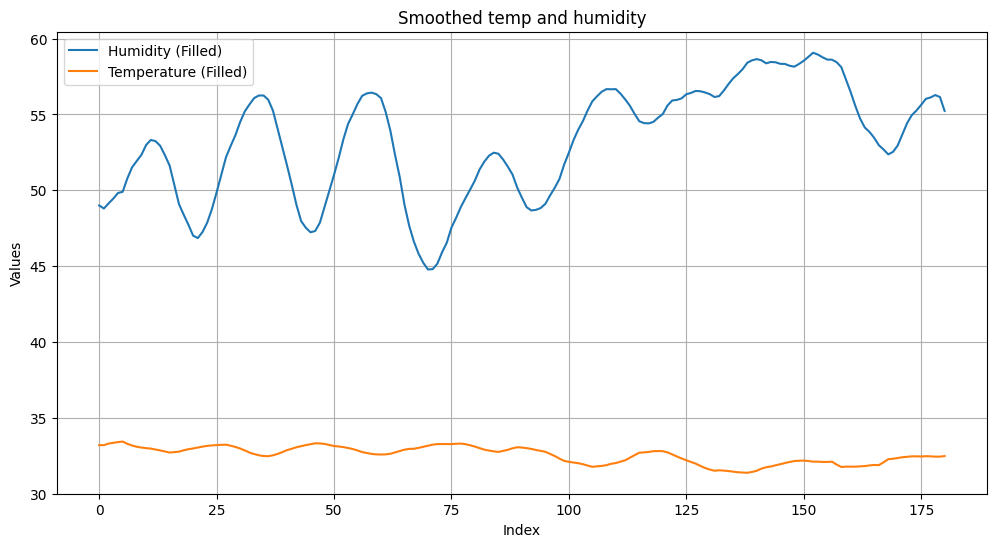

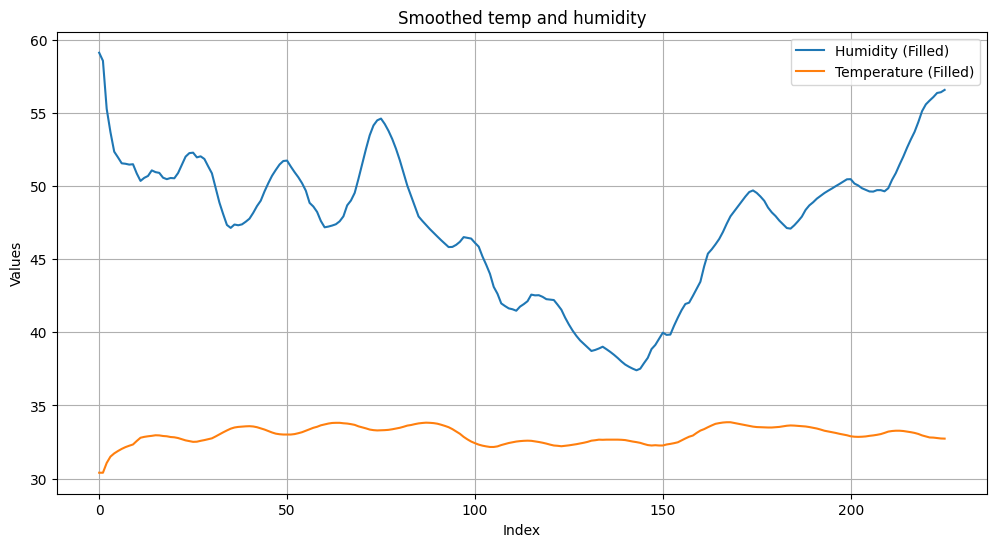

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df1['Hour'], df1['Hum'], label='Humidity (Filled)')
plt.plot(df1['Hour'], df1['Temp'], label='Temperature (Filled)')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Smoothed temp and humidity")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df2['Hour'], df2['Hum'], label='Humidity (Filled)')
plt.plot(df2['Hour'], df2['Temp'], label='Temperature (Filled)')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Smoothed temp and humidity")
plt.legend()
plt.grid(True)
plt.show()

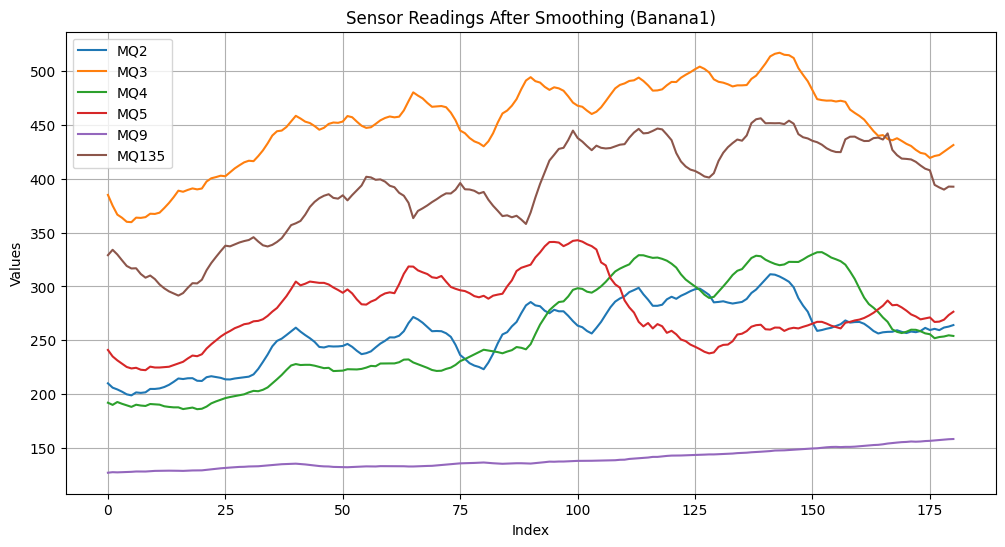

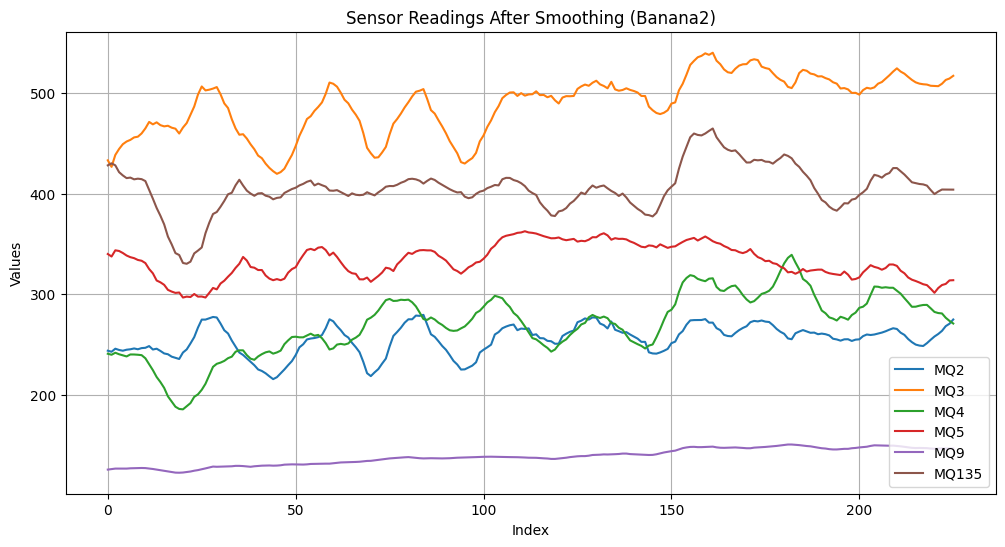

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df1['Hour'], df1['MQ2'], label='MQ2')
plt.plot(df1['Hour'], df1['MQ3'], label='MQ3')
plt.plot(df1['Hour'], df1['MQ4'], label='MQ4')
plt.plot(df1['Hour'], df1['MQ5'], label='MQ5')
plt.plot(df1['Hour'], df1['MQ9'], label='MQ9')
plt.plot(df1['Hour'], df1['MQ135'], label='MQ135')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Sensor Readings After Smoothing (Banana1)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df2['Hour'], df2['MQ2'], label='MQ2')
plt.plot(df2['Hour'], df2['MQ3'], label='MQ3')
plt.plot(df2['Hour'], df2['MQ4'], label='MQ4')
plt.plot(df2['Hour'], df2['MQ5'], label='MQ5')
plt.plot(df2['Hour'], df2['MQ9'], label='MQ9')
plt.plot(df2['Hour'], df2['MQ135'], label='MQ135')
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Sensor Readings After Smoothing (Banana2)")
plt.legend()
plt.grid(True)
plt.show()

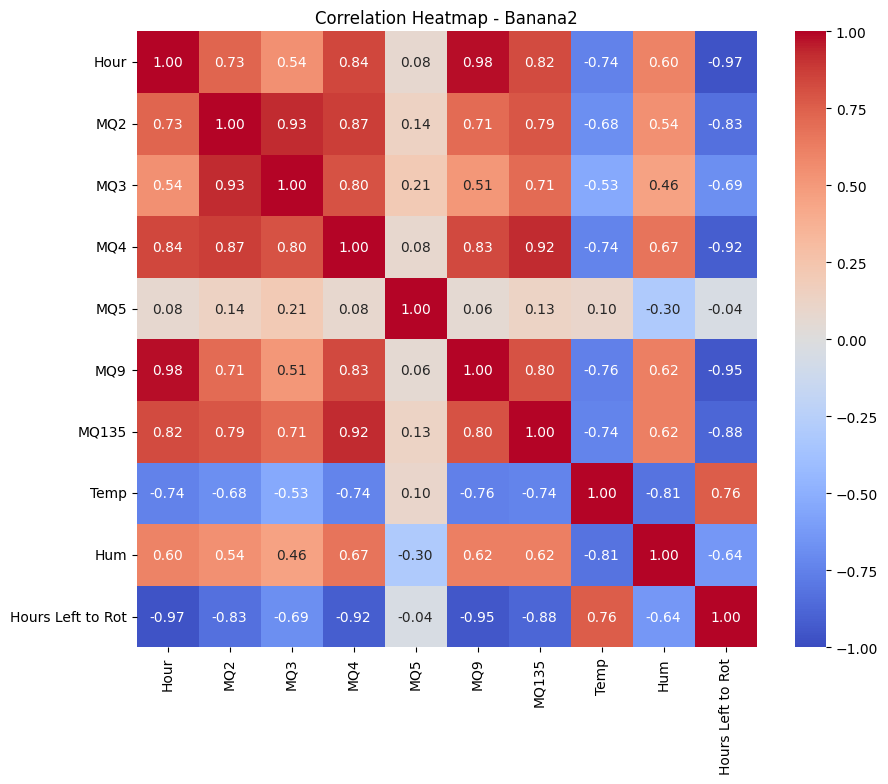

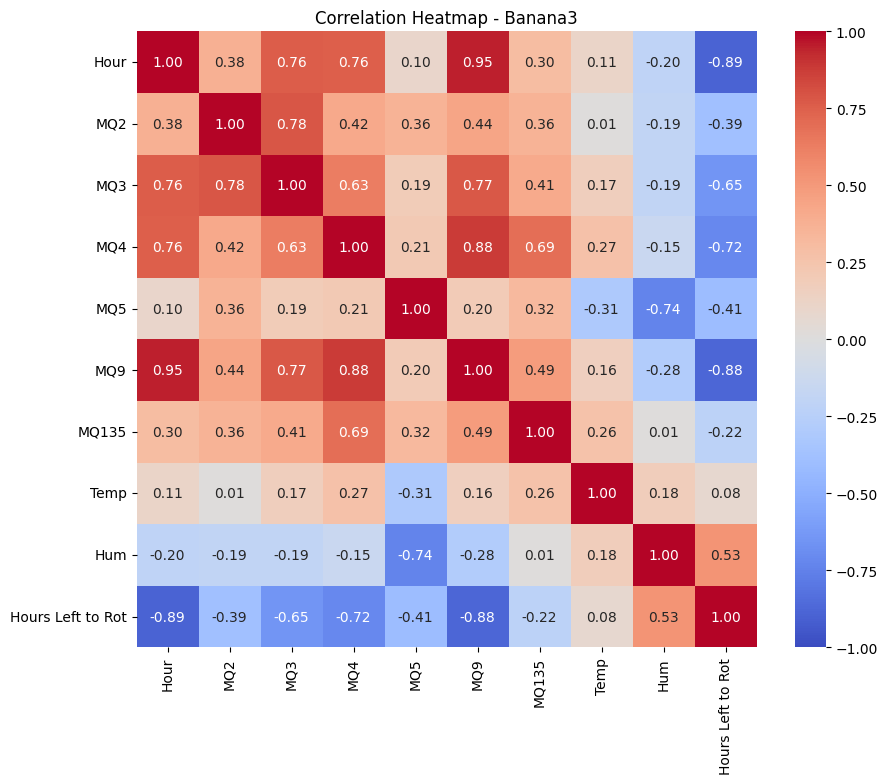

In [ ]:
correlation_matrix1 = df1.corr(method='spearman')
correlation_matrix2 = df2.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap - Banana2')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap - Banana3')
plt.show()

In [13]:
df = pd.concat([df1, df2], ignore_index=True)
df

,Hour,MQ2,MQ3,MQ4,MQ5,MQ9,MQ135,Temp,Hum,Hours Left to Rot
0,0,210.000000,385.000000,192.000000,241.000000,127.000000,329.000000,33.20,49.000000,109
1,1,206.000000,375.000000,190.000000,235.000000,127.500000,334.000000,33.20,48.800000,108
2,2,204.333333,366.666667,192.666667,231.333333,127.333333,329.666667,33.30,49.133333,107
3,3,202.250000,363.750000,191.000000,228.250000,127.500000,324.250000,33.35,49.450000,106
4,4,199.800000,360.000000,189.600000,225.200000,127.600000,319.000000,33.40,49.820000,105
...,...,...,...,...,...,...,...,...,...,...
402,221,260.600000,506.600000,281.400000,306.200000,146.900000,402.000000,32.81,55.830000,0
403,222,263.700000,509.000000,281.000000,309.200000,147.000000,404.000000,32.80,56.070000,0
404,223,268.400000,512.800000,276.700000,310.300000,146.900000,404.000000,32.77,56.350000,0
405,224,270.800000,514.200000,273.600000,313.800000,146.900000,404.000000,32.74,56.400000,0


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

features = ['Temp', 'Hum', 'MQ2', 'MQ3', 'MQ4', 'MQ5', 'MQ9', 'MQ135']
target = 'Hours Left to Rot'

X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    })

results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
print(results_df)


               Model         MSE       RMSE        MAE  R2 Score
2            XGBoost   20.741652   4.554300   1.739022  0.981177
1      Random Forest   21.061707   4.589304   1.929024  0.980887
3                SVR   24.797393   4.979698   2.101061  0.977497
0  Linear Regression  154.523834  12.430762  10.111831  0.859771


In [16]:
df_filtered = df[df['Hours Left to Rot'] > 0].copy()
df_filtered

,Hour,MQ2,MQ3,MQ4,MQ5,MQ9,MQ135,Temp,Hum,Hours Left to Rot
0,0,210.000000,385.000000,192.000000,241.000000,127.000000,329.000000,33.20,49.000000,109
1,1,206.000000,375.000000,190.000000,235.000000,127.500000,334.000000,33.20,48.800000,108
2,2,204.333333,366.666667,192.666667,231.333333,127.333333,329.666667,33.30,49.133333,107
3,3,202.250000,363.750000,191.000000,228.250000,127.500000,324.250000,33.35,49.450000,106
4,4,199.800000,360.000000,189.600000,225.200000,127.600000,319.000000,33.40,49.820000,105
...,...,...,...,...,...,...,...,...,...,...
270,89,248.700000,466.600000,269.600000,336.100000,137.100000,408.600000,33.79,46.790000,5
271,90,244.900000,459.800000,266.600000,333.500000,137.200000,406.500000,33.75,46.540000,4
272,91,239.600000,452.000000,264.300000,329.200000,137.300000,404.300000,33.68,46.290000,3
273,92,233.900000,446.100000,263.700000,324.800000,137.600000,402.500000,33.60,46.060000,2


In [17]:
features = ['Temp', 'Hum', 'MQ2', 'MQ3', 'MQ4', 'MQ5', 'MQ9', 'MQ135']
target = 'Hours Left to Rot'

X = df_filtered[features]
y = df_filtered[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    })

results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
print(results_df)


               Model        MSE      RMSE       MAE  R2 Score
3                SVR  20.787750  4.559358  2.588759  0.969517
2            XGBoost  61.994843  7.873680  3.548310  0.909092
0  Linear Regression  65.444802  8.089796  6.891669  0.904033
1      Random Forest  81.940002  9.052072  4.817317  0.879845
